In [20]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET
import omnifold_routine
import PET
sys.path.append('.')
from my_utils import *

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="0" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_singletop_herwig_DR.pkl')

omnifold_name = "closure_pythia_ttbarvsHerwig_singletop-knn_LR"
weight_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop'

In [4]:
herwig_df

,run,event,eventWeight,ptl1,truth_ptl1,etal1,truth_etal1,phil1,truth_phil1,ptb1,...,truth_mj4,mj5,truth_mj5,mj6,truth_mj6,met,truth_met,metphi,truth_metphi,pass_matched
0,357409,22508018,0.169604,81.982521,84.499298,-2.388170,-2.387469,-2.485019,-2.483407,95.355629,...,0.00000,0.0,0.0,0.0,0.0,46.444607,38.480560,1.921275,2.259534,1
1,350880,22509111,0.174083,74.778412,74.519630,0.740382,0.740931,-0.406289,-0.406354,100.180794,...,0.00000,0.0,0.0,0.0,0.0,91.861198,75.036751,-0.843975,-1.118763,1
2,350531,22508867,0.167756,122.247360,121.482124,-0.186685,-0.187343,-0.720186,-0.720140,182.872467,...,5.80008,0.0,0.0,0.0,0.0,221.190186,206.596970,-1.270177,-1.151998,1
3,352394,22508341,0.096564,36.271080,36.235218,1.136148,1.136315,-1.632233,-1.631952,72.792068,...,0.00000,0.0,0.0,0.0,0.0,123.313614,70.481453,0.218302,0.450134,1
4,364098,22508882,0.152495,98.434067,101.572662,2.427591,2.428012,0.874990,0.874992,133.095703,...,0.00000,0.0,0.0,0.0,0.0,30.532061,9.217309,-2.734150,2.997609,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328978,349693,37435212,0.141358,0.000000,80.803581,0.000000,-0.446216,0.000000,-2.178269,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,16.233683,0.000000,2.460174,2
2328979,355563,37434876,0.141358,0.000000,62.045506,0.000000,-0.114105,0.000000,-0.832910,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,101.102814,0.000000,-1.732641,2
2328980,360129,37435182,0.141358,0.000000,32.287067,0.000000,1.695242,0.000000,-1.874062,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,82.467316,0.000000,-0.695671,2
2328981,352056,37435028,0.141358,0.000000,54.756611,0.000000,-1.584736,0.000000,-1.205661,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,65.964790,0.000000,-0.382474,2


In [3]:
pythia_train, pythia_test = subset(pythia_df, 1_000_000, train_test=True)
herwig_subset = subset(herwig_df, 1_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
herwig_reco, herwig_truth = MC_data_shaper(herwig_subset)

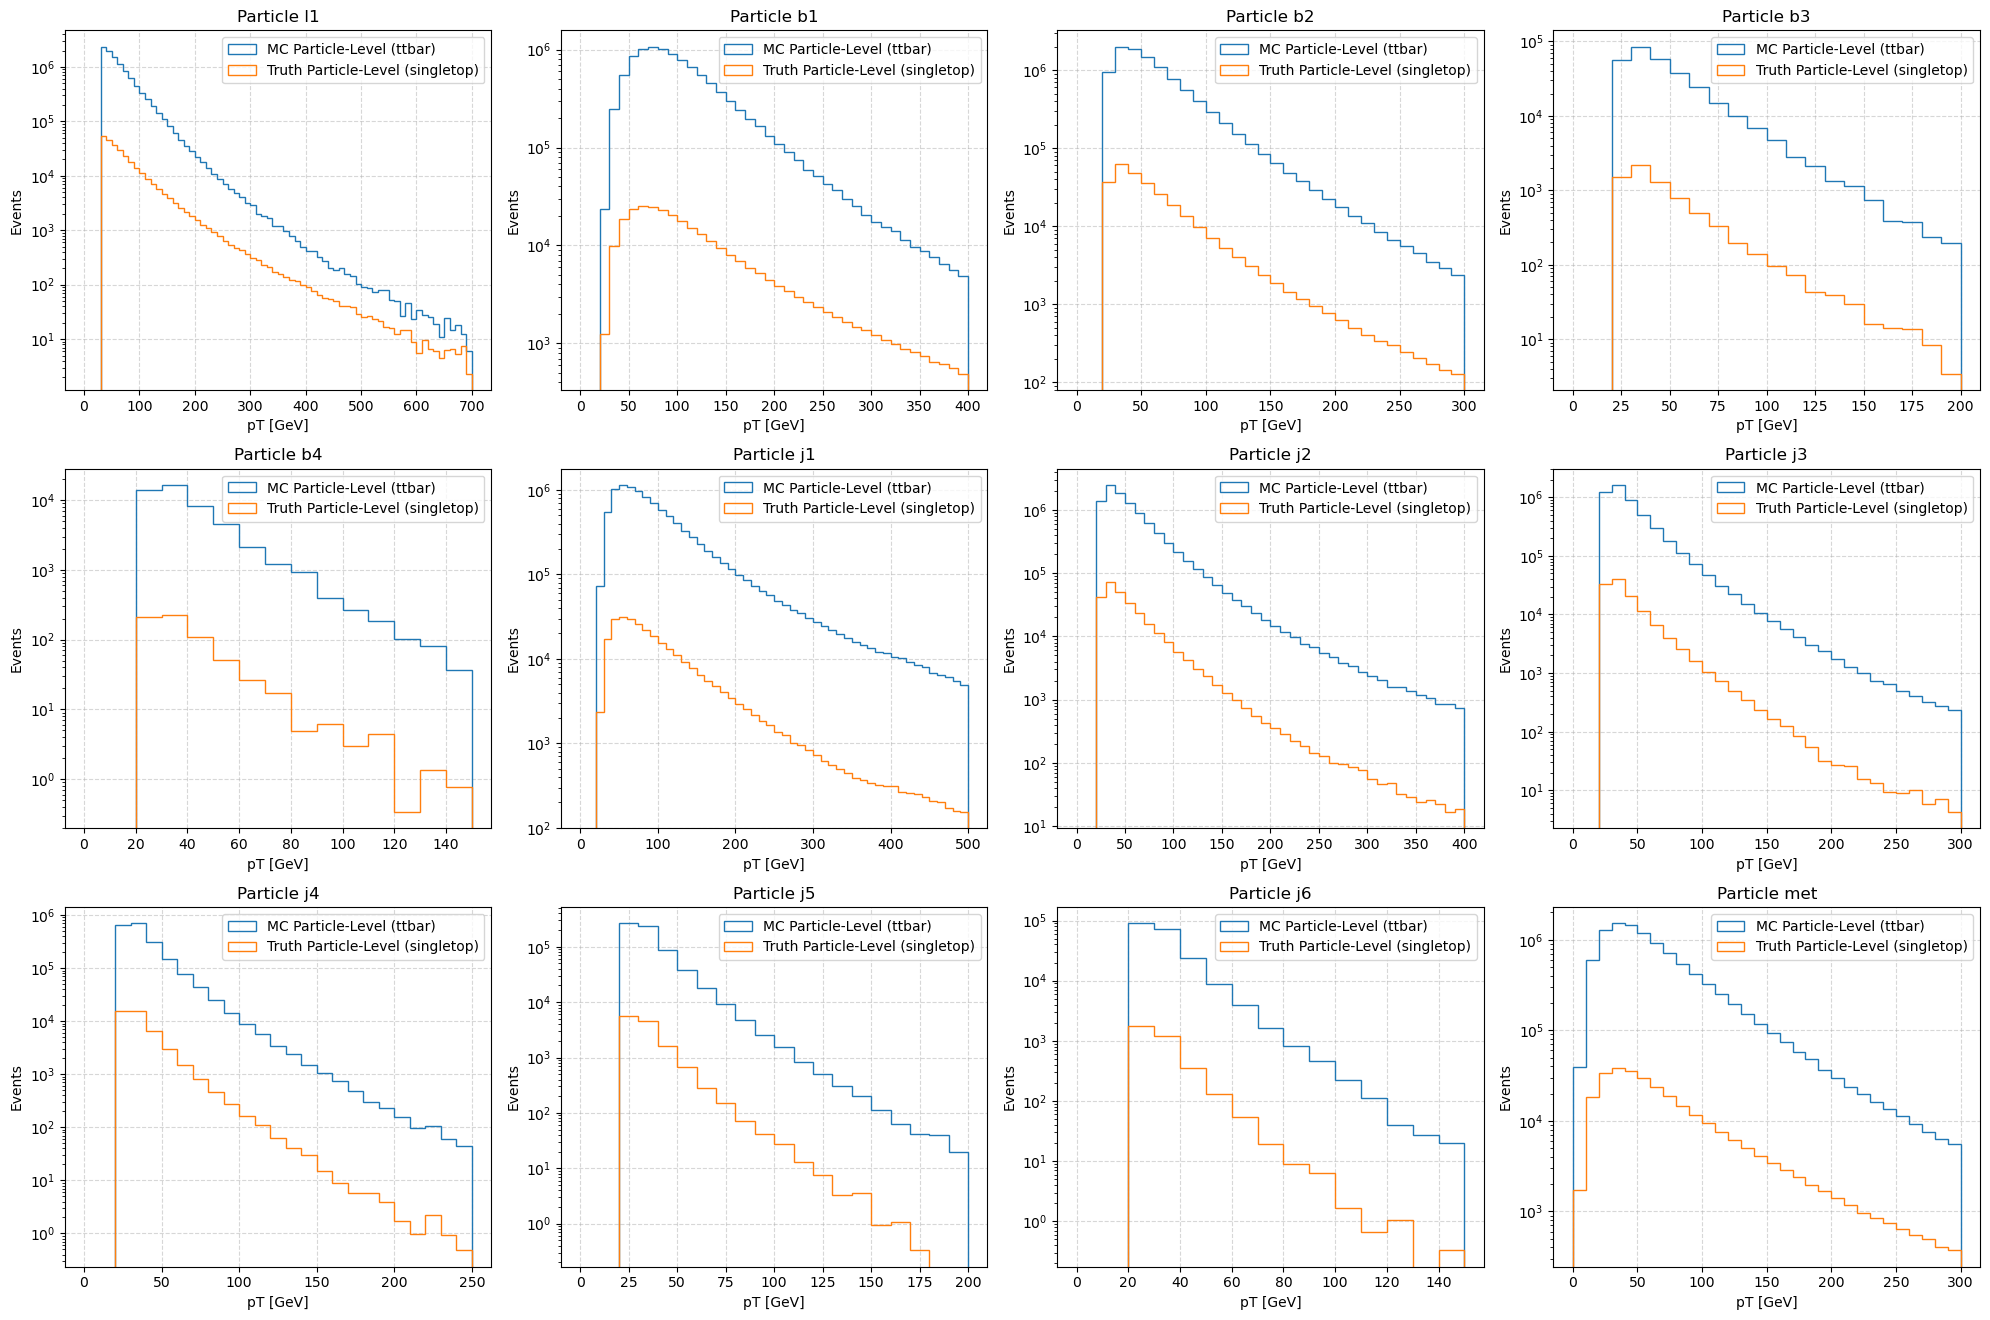

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']
pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    # masks for non-zero (non-padded) pT entries
    mask_pythia = pythia_truth_train[:, i, 0] != 0
    mask_herwig = herwig_truth[:, i, 0] != 0

    # Use .values[...] to align numpy masks with pandas Series
    ax.hist(
        pythia_truth_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_particle'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Particle-Level (ttbar)'
    )
    ax.hist(
        herwig_truth[:, i, 0][mask_herwig],
        weights=(herwig_subset['eventWeight'] * herwig_subset['pass_particle'])[mask_herwig],
        bins=bins,
        histtype='step',
        label='Truth Particle-Level (singletop)'
    )
    
    ax.set_title(f"Particle {pname}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_yscale('log')
    

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

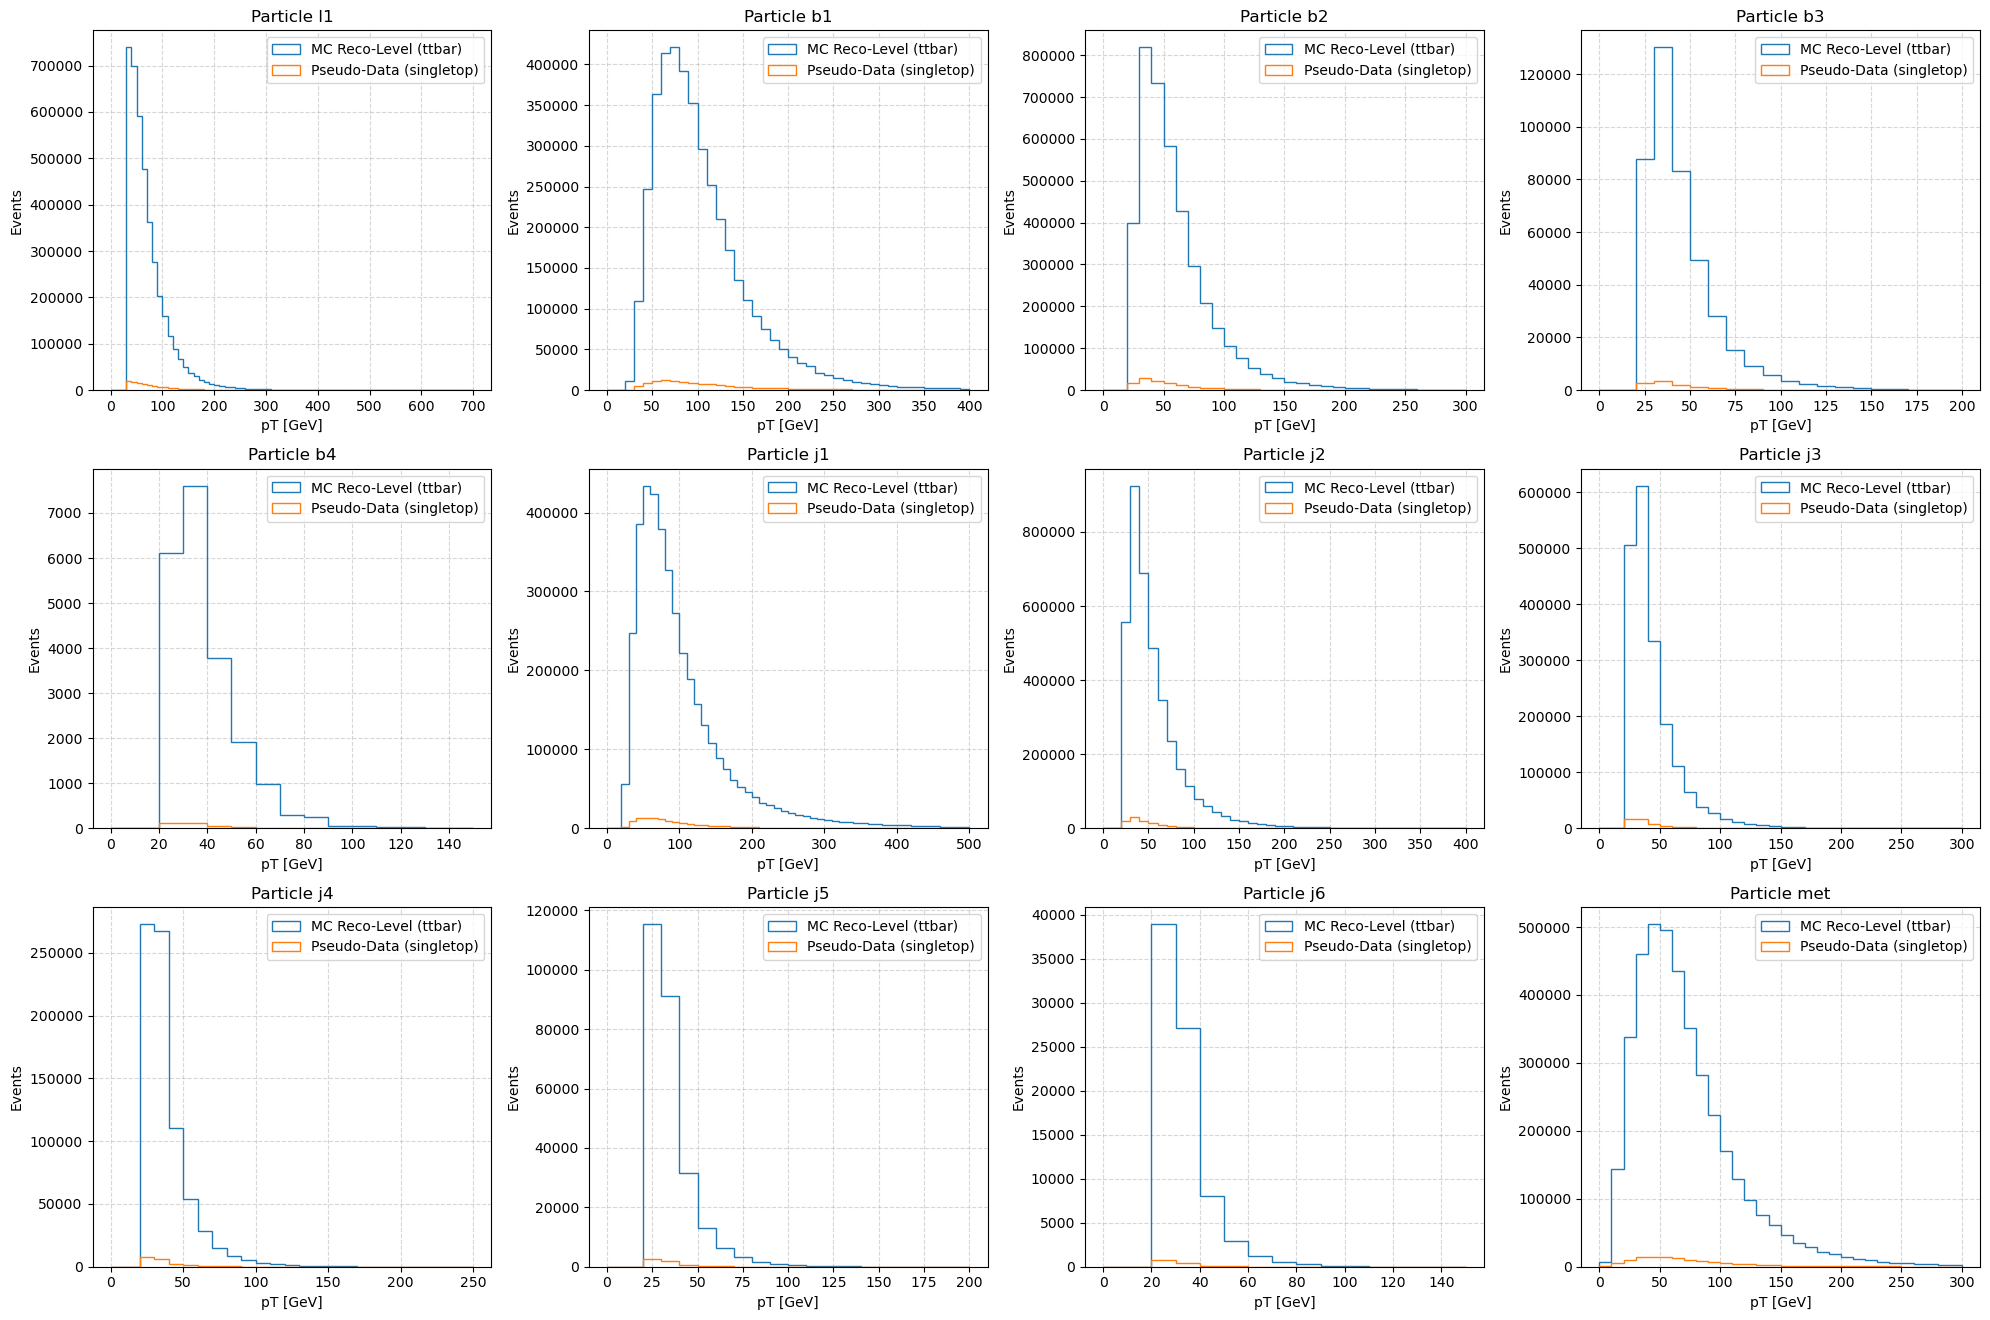

In [12]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']
pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    # masks for non-zero (non-padded) pT entries
    mask_pythia = pythia_reco_train[:, i, 0] != 0
    mask_herwig = herwig_reco[:, i, 0] != 0

    # Use .values[...] to align numpy masks with pandas Series
    ax.hist(
        pythia_reco_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_reco'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Reco-Level (ttbar)'
    )
    ax.hist(
        herwig_reco[:, i, 0][mask_herwig],
        weights=(herwig_subset['eventWeight'] * herwig_subset['pass_reco'])[mask_herwig],
        bins=bins,
        histtype='step',
        label='Pseudo-Data (singletop)'
    )
    
    ax.set_title(f"Particle {pname}")
    ax.legend()
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.grid(True, linestyle='--', alpha=0.5)
    


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [6]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [7]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

In [8]:
herwig_loader = DataLoader(reco = X_herwig_reco_scaled, gen = X_herwig_truth_scaled, weight = herwig_subset['eventWeight'],
                           pass_reco = herwig_subset['pass_reco'], pass_gen = herwig_subset['pass_particle'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train['eventWeight'],
                           pass_reco = pythia_train['pass_reco'], pass_gen = pythia_train['pass_particle'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test['eventWeight'],
                           pass_reco = pythia_test['pass_reco'], pass_gen = pythia_test['pass_particle'], normalize=False)


In [9]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 14 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=True, K=4)
model2 = PET.PET(num_feat = 4, num_part = 12, local=True, K=4)
#model2 = build_transformer_model()

I0000 00:00:1762871054.779263 3318187 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 135935 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:03:00.0, compute capability: 9.0


In [21]:
importlib.reload(omnifold_routine)

Horovod not found, will continue with single only GPUs.


<module 'omnifold_routine' from '/scratch/mjosef/Unfolding/omnifold/omnifold_routine.py'>

In [ ]:
omnifold = omnifold_routine.MultiFold(
    omnifold_name,
    model1, # model_reco
    model2, # model_gen
    herwig_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 7,  #Number of Iterations                                                                                                                                                                                                  
    epochs=150,     
    weights_folder = weight_folder,
    verbose = True,
    early_stop=8,
    lr = 1e-4,
)

15625 training steps at reco and 15625 steps at gen


In [23]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.5569 - loss: 0.3377 - val_accuracy: 0.5581 - val_loss: 0.2723 - learning_rate: 1.0000e-04
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.5574 - loss: 0.2727 - val_accuracy: 0.5581 - val_loss: 0.2719 - learning_rate: 1.0000e-04
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.5573 - loss: 0.2719 - val_accuracy: 0.5581 - val_loss: 0.2726 - learning_rate: 1.0000e-04
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.5568 - loss: 0.2720 - val_accuracy: 0.5581 - val_loss: 0.2705 - learning_rate: 1.0000e-04
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.5570

In [24]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [25]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop/unfolded_weights-linear.npy", unfolded_weights)

In [ ]:
#unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop/unfolded_weights.npy")

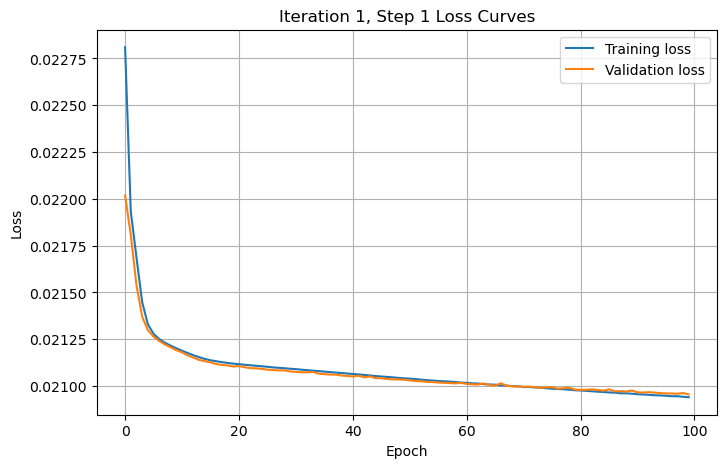

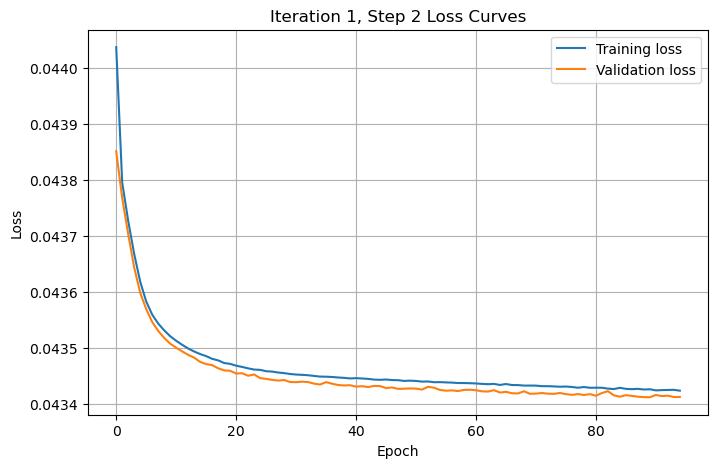

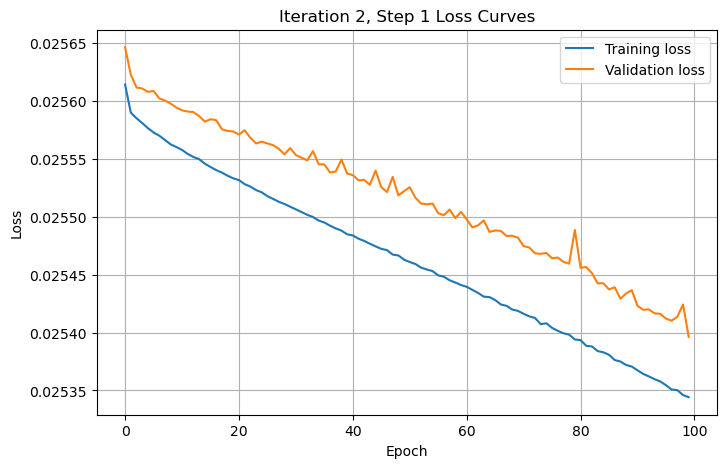

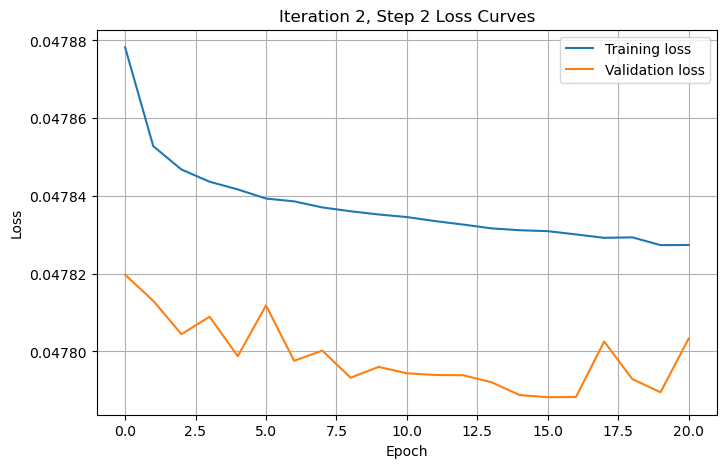

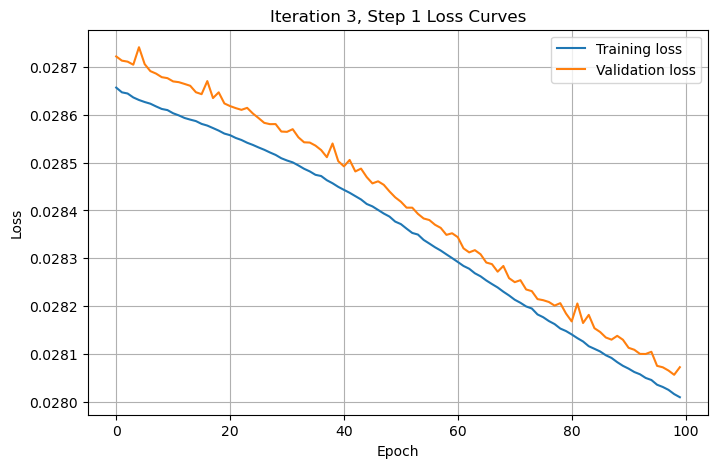

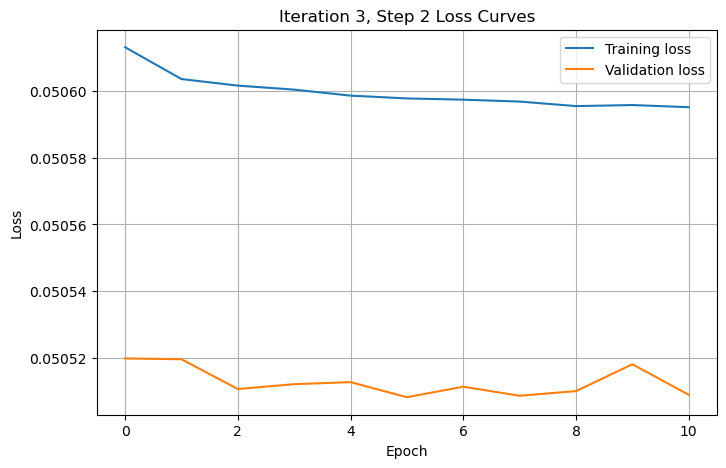

In [26]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_singletop'      
name = "closure_pythia_ttbarvsHerwig_singletop_linear"    
niter = 3                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


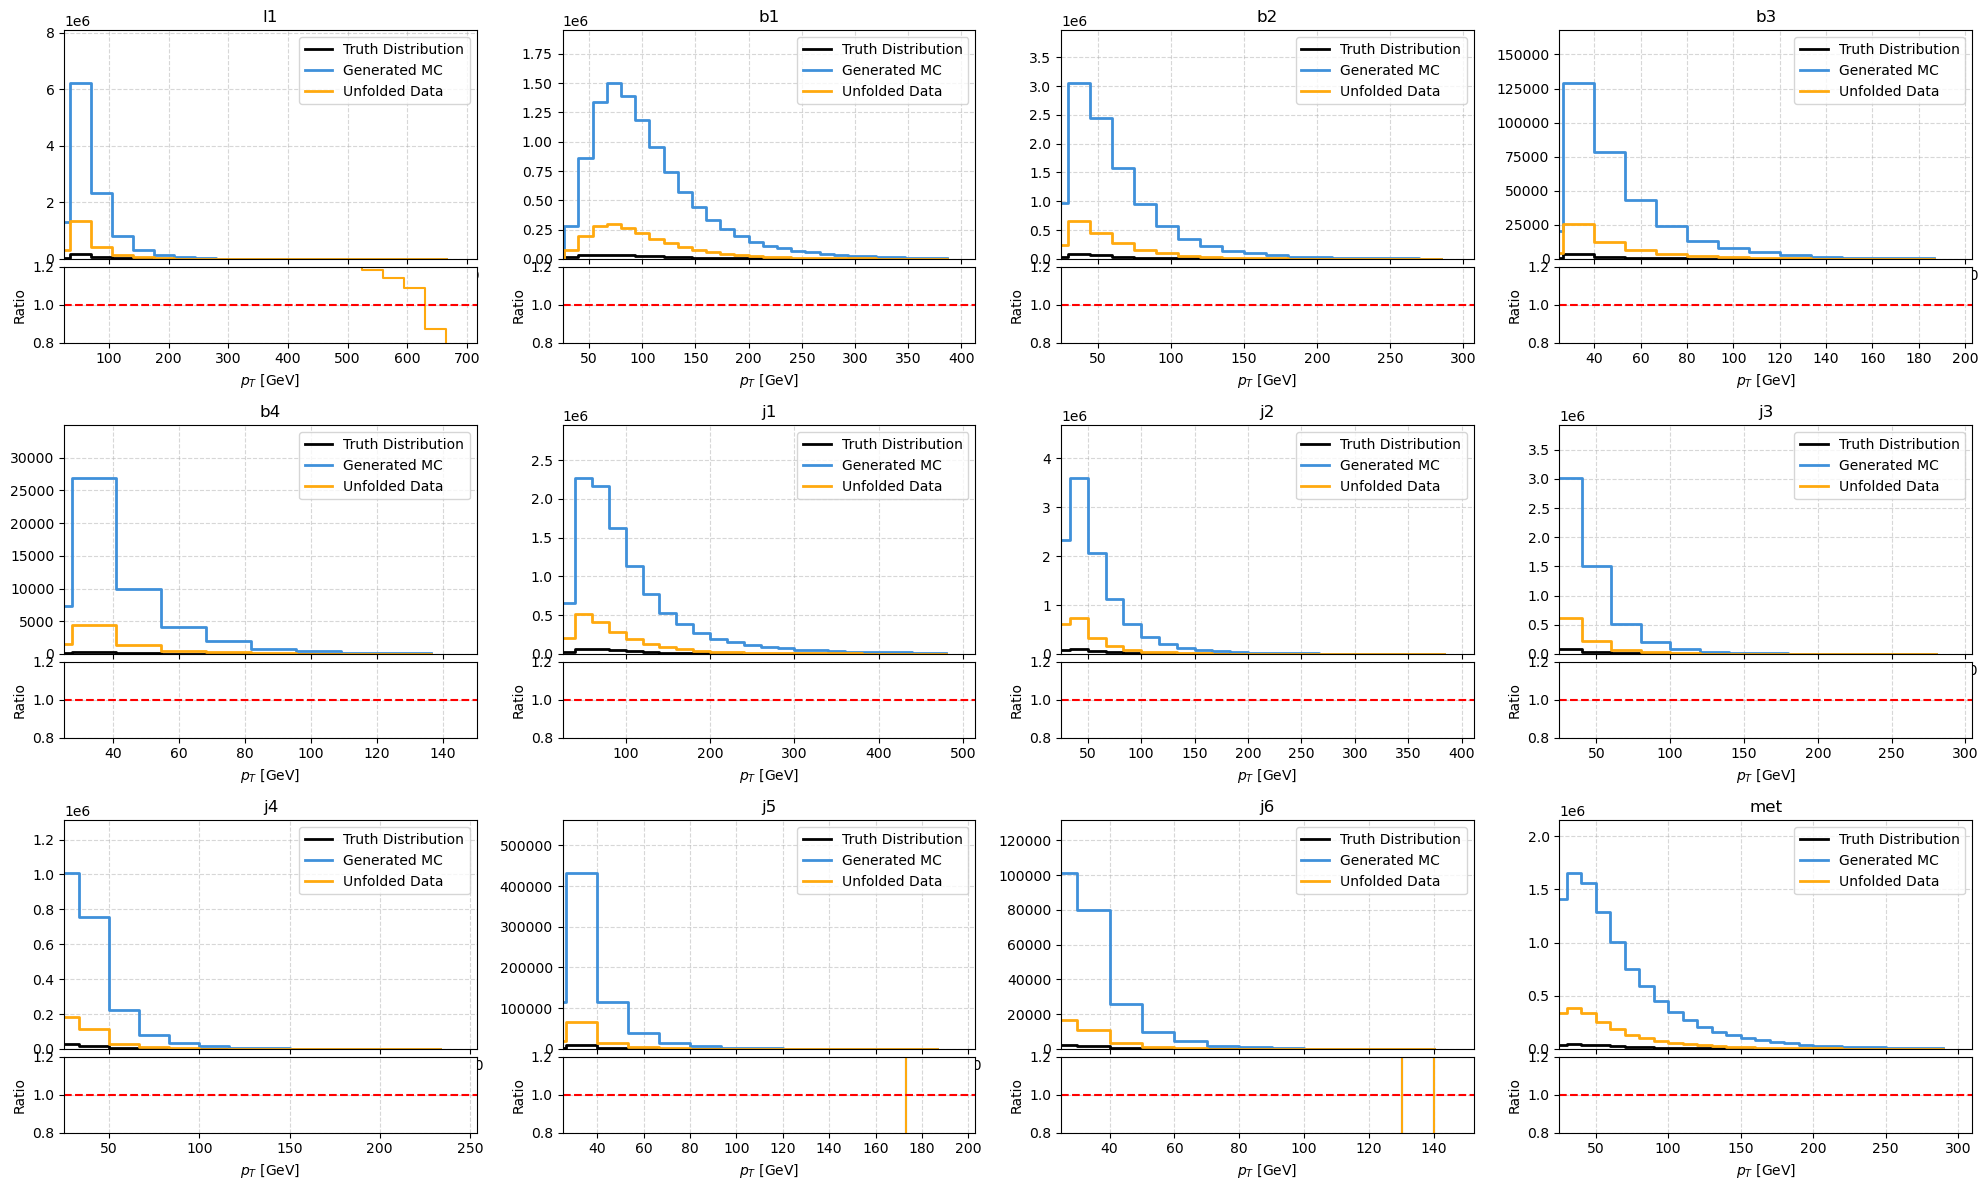

In [26]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 
             'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 700, 21),
    'b1': np.linspace(0, 400, 31),
    'b2': np.linspace(0, 300, 21),
    'b3': np.linspace(0, 200, 16),
    'b4': np.linspace(0, 150, 12),
    'j1': np.linspace(0, 500, 26),
    'j2': np.linspace(0, 400, 25),
    'j3': np.linspace(0, 300, 16),
    'j4': np.linspace(0, 250, 16),
    'j5': np.linspace(0, 200, 16),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}

# Function to plot one particle pt with ratio
def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):
    x_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Reference histogram: first entry
    ref_name = list(data_dict.keys())[0]
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    
    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e', '#bd1f01']  # adjust as needed
    
    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label, linewidth=2)
        maxy = max(maxy, counts.max())
        
        if ax_ratio is not None and i > 0:  # skip reference
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts!=0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=f"{label}/{ref_name}")
    
    ax_main.set_ylim(0, 1.3*maxy)
    ax_main.set_xlim(25,)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend(fontsize=10)
    if ax_ratio is not None:
        ax_ratio.axhline(1.0, color='r', linestyle='--')
        ax_ratio.set_ylim(0.8, 1.2)
        ax_ratio.set_xlabel(r"$p_T$ [GeV]")
        ax_ratio.set_ylabel("Ratio")
        ax_ratio.grid(True, linestyle='--', alpha=0.5)

# --- Create figure with 3x4 subplots ---
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for i, pname in enumerate(particles[:12]):
    # Prepare data
    data_dict = {
        'Truth Distribution': herwig_truth[:, i, 0][herwig_truth[:, i, 0] != 0],
        'Generated MC': pythia_truth_test[:, i, 0][pythia_truth_test[:, i, 0] != 0],
        'Unfolded Data': pythia_truth_test[:, i, 0][pythia_truth_test[:, i, 0] != 0],
    }
    weight_dict = {
        'Truth Distribution': herwig_subset['eventWeight'][herwig_truth[:, i, 0] != 0],
        'Generated MC': pythia_test['eventWeight'][pythia_truth_test[:, i, 0] != 0],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[pythia_truth_test[:, i, 0] != 0],
    }
    
    # Create a small inset for ratio
    # Here we just stack main+ratio manually inside the same subplot
    # Define height ratios
    gs = axes[i].get_gridspec()
    for ax in axes[i].get_shared_x_axes().get_siblings(axes[i]):
        ax.remove()
    
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1], subplot_spec=gs[i], hspace=0.05)
    ax_main = fig.add_subplot(sub_gs[0])
    ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
    
    plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
    
    ax_main.set_title(pname)

plt.tight_layout()
plt.show()

In [30]:
n_iterations   = 5
n_ensembles    = 1
weights_plots_folder = f"weight_plots_{omnifold_name}"
os.makedirs(os.path.join(weight_folder, weights_plots_folder), exist_ok=True)

# --------------------------------------------------------
# LOAD WEIGHTS FUNCTION
def load_unfolded_weights(iteration, stepn, ensemble=0):
    model_name = f"{weight_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
    if n_ensembles > 1:
        model_name += f"_ensemble{ensemble}"
    model_name += ".weights.h5"

    if not os.path.exists(model_name):
        return None

    if stepn ==1:
        my_model = omnifold.model1
        iterative_weights = np.zeros((len(Y_reco_scaled)))
        in_data = Y_reco_scaled
    elif stepn==2:
        my_model = omnifold.model2
        iterative_weights = np.zeros((len(Y_truth_scaled)))
        in_data = Y_truth_scaled

    # 🧩 Ensure model is built before loading weights
    _ = my_model.build(input_shape=(None, 12, 4))    # or use my_model.build(input_shape=(None, Y_truth_scaled.shape[1]))

    my_model.load_weights(model_name)
    f = omnifold_routine.expit(my_model.predict(in_data,batch_size=1000))
    weights = f / (1. - f)  # this is the crux of the reweight, approximates likelihood ratio
    weights = np.nan_to_num(weights[:,0],posinf=1)
    iterative_weights += weights
    return iterative_weights

# --------------------------------------------------------
# PLOT FOR EACH ITERATION
# --------------------------------------------------------
def plot_iteration(iteration, unfolded_weights, stepn):
    fig = plt.figure(figsize=(20, 12))
    outer_gs = fig.add_gridspec(3, 4, wspace=0.3, hspace=0.3)

    for i, pname in enumerate(particles[:12]):
        sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1],
                                         subplot_spec=outer_gs[i], hspace=0.05)
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
        if stepn==1:
            data_dict = {
                'Pseudo-Data Reco-Level': herwig_reco[:, i, 0][herwig_reco[:, i, 0] != 0],
                'MC Reco-Level': pythia_reco_test[:, i, 0][pythia_reco_test[:, i, 0] != 0],
                'Reweighted Reco-Level (OmniFold)': pythia_reco_test[:, i, 0][pythia_reco_test[:, i, 0] != 0],
            }
            weight_dict = {
                'Pseudo-Data Reco-Level': herwig_subset['eventWeight'][herwig_reco[:, i, 0] != 0],
                'MC Reco-Level': pythia_test['eventWeight'][pythia_reco_test[:, i, 0] != 0],
                'Reweighted Reco-Level (OmniFold)': (unfolded_weights * pythia_test['eventWeight'])[pythia_reco_test[:, i, 0] != 0],
            }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
            ax_main.set_title(pname, fontsize=10)
            fig.suptitle("Reco-Level", fontsize=16)

        elif stepn==2:
            data_dict = {
                'Truth Distribution': herwig_truth[:, i, 0][herwig_truth[:, i, 0] != 0],
                'Generated MC': pythia_truth_test[:, i, 0][pythia_truth_test[:, i, 0] != 0],
                'Unfolded Data': pythia_truth_test[:, i, 0][pythia_truth_test[:, i, 0] != 0],
            }
            weight_dict = {
                'Truth Distribution': herwig_subset['eventWeight'][herwig_truth[:, i, 0] != 0],
                'Generated MC': pythia_test['eventWeight'][pythia_truth_test[:, i, 0] != 0],
                'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[pythia_truth_test[:, i, 0] != 0],
            }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
            ax_main.set_title(pname, fontsize=10)
            fig.suptitle("Particle-Level", fontsize=16)

    plt.tight_layout()
    out_path = os.path.join(weight_folder, weights_plots_folder, f"plot_iter{iteration+1}_step{stepn}.png")
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved 3×4 grid plot for iteration {iteration+1}")


# --------------------------------------------------------
# MAIN LOOP
# --------------------------------------------------------
for i in range(n_iterations):
    omnifold_weights = load_unfolded_weights(i, stepn=2)
    if omnifold_weights is not None:
        plot_iteration(i, omnifold_weights, stepn=2)

   1/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step

/opt/conda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 100 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/tmp/ipykernel_3318187/1050914650.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved 3×4 grid plot for iteration 1
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Saved 3×4 grid plot for iteration 2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved 3×4 grid plot for iteration 3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved 3×4 grid plot for iteration 4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved 3×4 grid plot for iteration 5


(<Figure size 900x900 with 2 Axes>, <Axes: ylabel='# Events'>)

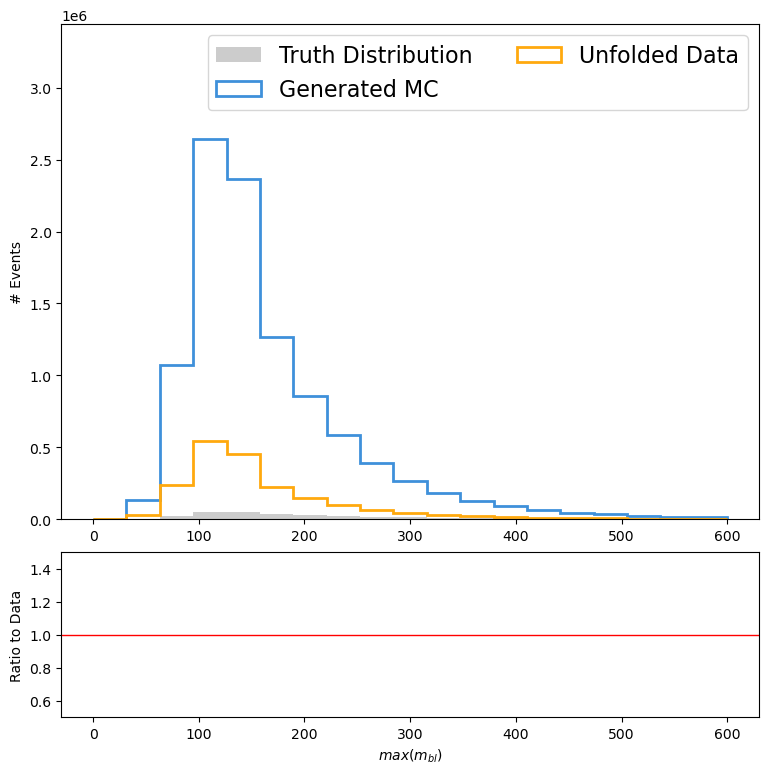

In [28]:
data_dict_mbl = {
        'Truth Distribution': max_mbl(herwig_truth),
        'Generated MC': max_mbl(pythia_truth_test),
        'Unfolded Data': max_mbl(pythia_truth_test),
    }
weight_dict_mbl = {
        'Truth Distribution': herwig_subset['eventWeight']*herwig_subset['pass_particle'],
        'Generated MC': pythia_test['eventWeight']*pythia_test['pass_particle'],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])*pythia_test['pass_particle'],
    }

HistRoutine(
        data_dict_mbl,
        f"$max(m_{{bl}})$",
        ylabel="# Events",
        reference_name='Truth Distribution',
        weights=weight_dict_mbl,
        plot_ratio=True,
        binning=np.linspace(0,600, 20),
    )

(<Figure size 900x900 with 2 Axes>, <Axes: ylabel='# Events'>)

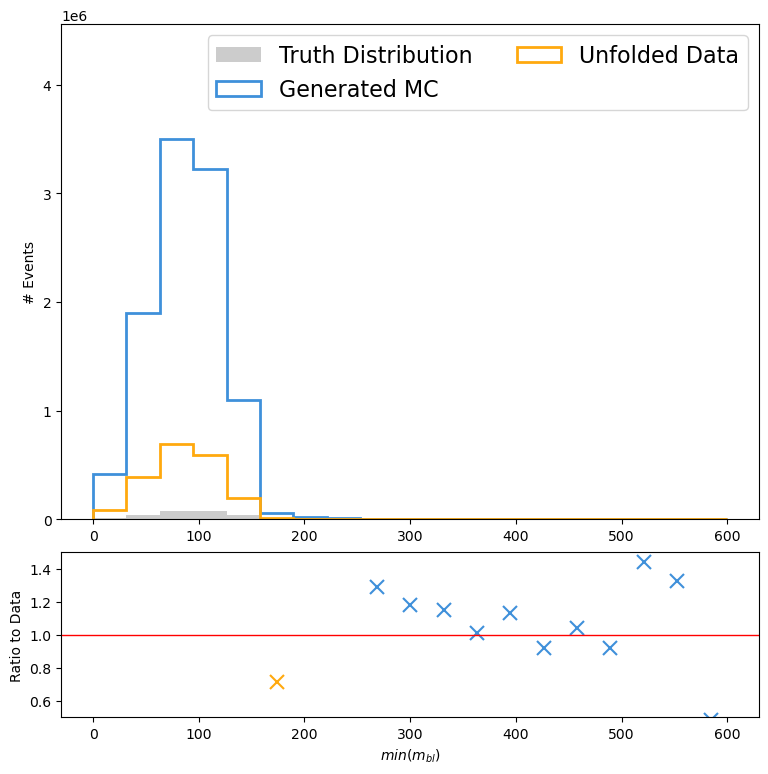

In [29]:
data_dict_mbl = {
        'Truth Distribution': min_mbl(herwig_truth),
        'Generated MC': min_mbl(pythia_truth_test),
        'Unfolded Data': min_mbl(pythia_truth_test),
    }
weight_dict_mbl = {
        'Truth Distribution': herwig_subset['eventWeight']*herwig_subset['pass_particle'],
        'Generated MC': pythia_test['eventWeight']*pythia_test['pass_particle'],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])*pythia_test['pass_particle'],
    }

HistRoutine(
        data_dict_mbl,
        f"$min(m_{{bl}})$",
        ylabel="# Events",
        reference_name='Truth Distribution',
        weights=weight_dict_mbl,
        plot_ratio=True,
        binning=np.linspace(0,600, 20),
    )